## PCA for the equation of state
In this notebook, prinicipal components are obtained by varying the dark fluid equation of state $w_d$, while keeping the sound speed fixed to the fiducial.

In [11]:
import params as par
from background import *
import numba
from scipy.special import spherical_jn
from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import copy
import pickle
from IPython.display import ScribdDocument

plt.rcParams.update(par.plot_params)
cp = copy.deepcopy

In [2]:
# Load data from GDM_FID.

τ_solve = pickle.load(open( "data/tau_solve.p", "rb" ) )
k_solve = pickle.load(open( "data/k_solve.p", "rb" ) )

wd_F = pickle.load(open( "data/w_d.p", "rb" ) )
Dwd_F = pickle.load(open( "data/Dw_d.p", "rb" ) )
cs2d_F = pickle.load(open( "data/cs2_d.p", "rb" ) )

δd = pickle.load(open( "data/delta_d.p", "rb" ) )
vd = pickle.load(open( "data/v_d.p", "rb" ) )
δɣ = pickle.load(open( "data/delta_g.p", "rb" ) )
vν= pickle.load(open( "data/v_g.p", "rb" ) )
δν= pickle.load(open( "data/delta_g.p", "rb" ) )
vɣ = pickle.load(open( "data/v_g.p", "rb" ) )
Φ = pickle.load(open( "data/phi.p", "rb" ) )

(wd, Dwd, cs2d) =(wd_F, Dwd_F, cs2d_F)

## 2-fluid GDM system
Now solve the system obtained with the GDM substitutions (and only two fluid components). We obtain initial condidtions for $\delta_d$ and $v_d$ by plugging the Seljak initial conditions into the definitions of these quantities.

In [3]:
"""2 fluid"""

# set initial conditions
Φ0  = Φ[:,0] 
δɣ0 = δɣ[:,0] 
vɣ0 = vɣ[:,0] 
δd0 = δd[:,0] 
vd0 = vd[:,0] 
δν0 = δν[:,0] 
vν0 = vν[:,0] 

Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0])

#@numba.jit(nopython=True)
def DY(τ, Y, wd, Dwd, Ωd_, H_, a_):
        dY = np.zeros((5,K_SOLVE))
        Φ = Y[0,:]
        δɣ = Y[1,:]
        vɣ = Y[2,:]
        δd = Y[3,:]
        vd = Y[4,:]
           
        #compute background quantities
        ℋi = H_(τ)
        ai =  a_(τ)
        Ωdi = Ωd_(τ)
        ybi = 1.68*ai*Ωb0/Ωr0

        Ωbi = Ωb0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.

        wdi = np.interp(τ, τ_solve, wd)
        Dwdi = np.interp(τ, τ_solve, Dwd)
        
        #interpolate cs2 (this is faster than scipy's interp1d)
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d
        
        f = vd*Ωdi*(1+wdi) + 4./3.*Ωɣi*vɣ +  Ωbi*vɣ
        dY[0,:]  = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f
        dY[1,:] = -4./3.*k_solve*vɣ + 4*dY[0,:]
        dY[2,:] = (-ℋi*ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ
        dY[3,:] = -(1+wdi)*(k_solve*vd-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δd
        dY[4,:] = -ℋi*(1-3*wdi)*vd - vd*Dwdi/(1+wdi) +\
            k_solve*δd*cs2di/(1+wdi) + k_solve*Φ
        return dY

In [4]:
# compute stepsizes for RK4
stepsizes = np.diff(τ_solve)
Ωd_τ0 = Ωc(τ0)+Ων(τ0)
a_list  =  a(τ_solve)

# integrate the ODE using RK4
def solve(wd, Dwd): 
    # Update the background:
    Ωd_a = Ωd_τ0 * np.exp(-3*
        integrate.cumtrapz((1+wd)/a_list,a_list, initial=0)
                      )
    H_a =  H0 *np.sqrt(Ωb0*a_list**-3 + Ωɣ0*a_list**-4 + Ωd_a + ΩΛ)*a_list
    τ_a =  integrate.cumtrapz(1/(a_list * H_a), a_list,initial=0)+τ0
    a_ =  interp1d(τ_a, a_list, kind='quadratic',fill_value='extrapolate')
    H_ = interp1d(τ_a, H_a, kind='quadratic',fill_value='extrapolate')
    Ωd_ = interp1d(τ_a, Ωd_a, kind='quadratic',fill_value='extrapolate')
    
    Y = np.zeros((len(τ_solve), 5, par.K_SOLVE))
    Y[0,:,:] = Y0
    for i, τi in enumerate(τ_solve[:-1]):
        ss = stepsizes[i]
        k1 = ss*DY(τi,Y[i,:,:], wd, Dwd, Ωd_,H_,a_)
        k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2, wd, Dwd, Ωd_,H_,a_)
        k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2, wd, Dwd, Ωd_,H_,a_)
        k4 = ss*DY(τi+ss,Y[i,:,:]+k3, wd, Dwd, Ωd_,H_,a_)
        
        Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

In [5]:
if settings['dark matter only']:
    Y0 = np.array([Φ0, δɣ0, vɣ0, δd0, vd0, δν0, vν0])
    def DY(τ, Y, wd, Dwd, Ωd_, H_, a_):
        dY = np.zeros((7, K_SOLVE))
        Φ = Y[0, :]
        δɣ = Y[1, :]
        vɣ = Y[2, :]
        δc = Y[3, :]
        vc = Y[4, :]
        δν = Y[5, :]
        vν = Y[6, :]

        ℋi = H_(τ)
        ai =  a_(τ)
        Ωdi = Ωd_(τ)
        ybi = 1.68*ai*Ωb0/Ωr0
        
        Ωbi = Ωb0 * ai**-3.
        Ωci = Ωc0 * ai**-3.
        Ωɣi = Ωɣ0 * ai**-4.
        Ωνi = Ων0 * ai**-4

        wdi = np.interp(τ, τ_solve, wd)
        Dwdi = np.interp(τ, τ_solve, Dwd)
        
        #interpolate cs2 (this is faster than scipy's interp1d)
        idx = np.searchsorted(τ_solve, τ) - 1
        d = (τ - τ_solve[idx]) / (τ_solve[idx + 1] - τ_solve[idx])
        cs2di = (1 - d) * cs2d[:,idx]   + cs2d[:,idx + 1] * d

        f = vc*Ωci*(1+wdi) + 4./3.*Ωɣi*vɣ + 4./3.*Ωνi*vν + Ωbi*vɣ
        # compute the derivatives of the perturbations.
        DΦ = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve)*f

        Dδɣ = -4./3.*k_solve*vɣ + 4*DΦ
        Dvɣ = (-ℋi * ybi*vɣ + k_solve*δɣ/3)/(
            4./3. + ybi) + k_solve*Φ

        Dδc = -(1+wdi)*(k_solve*vc-3*dY[0,:]) -\
            3*ℋi*(cs2di-wdi)*δc
        Dvc = -ℋi*(1-3*wdi)*vc - vc*Dwdi/(1+wdi) +\
            k_solve*δc*cs2di/(1+wdi) + k_solve*Φ

        Dδν = -4./3.*k_solve*vν + 4*DΦ
        Dvν = k_solve*δν/4 + k_solve*Φ

        dY[0, :] = DΦ
        dY[1, :] = Dδɣ
        dY[2, :] = Dvɣ
        dY[3, :] = Dδc
        dY[4, :] = Dvc
        dY[5, :] = Dδν
        dY[6, :] = Dvν

        return dY
    # compute stepsizes for RK4
    stepsizes = np.diff(τ_solve)
    Ωd_τ0 = Ωc(τ0)+Ων(τ0)
    a_list  =  a(τ_solve)

    # integrate the ODE using RK4
    def solve(wd, Dwd): 
        # Update the background:
        Ωd_a = Ωd_τ0 * np.exp(-3*
            integrate.cumtrapz((1+wd)/a_list,a_list, initial=0)
                          )
        H_a =  H0 *np.sqrt(Ωb0*a_list**-3 + (Ωɣ0+Ων0)*a_list**-4 + Ωd_a + ΩΛ)*a_list
        τ_a =  integrate.cumtrapz(1/(a_list * H_a), a_list,initial=0)+τ0
        a_ =  interp1d(τ_a, a_list, kind='quadratic',fill_value='extrapolate')
        H_ = interp1d(τ_a, H_a, kind='quadratic',fill_value='extrapolate')
        Ωd_ = interp1d(τ_a, Ωd_a, kind='quadratic',fill_value='extrapolate')

        Y = np.zeros((len(τ_solve), 7, par.K_SOLVE))
        Y[0,:,:] = Y0
        for i, τi in enumerate(τ_solve[:-1]):
            ss = stepsizes[i]
            k1 = ss*DY(τi,Y[i,:,:], wd, Dwd, Ωd_,H_,a_)
            k2 = ss*DY(τi+ss/2,Y[i,:,:]+k1/2, wd, Dwd, Ωd_,H_,a_)
            k3 = ss*DY(τi+ss/2,Y[i,:,:]+k2/2, wd, Dwd, Ωd_,H_,a_)
            k4 = ss*DY(τi+ss,Y[i,:,:]+k3, wd, Dwd, Ωd_,H_,a_)

            Y[i+1,:,:] = Y[i,:,:] + k1/6 + k2/3 + k3/3 + k4/6
        return Y

## Integrating over $k$
A new list of wavenumbers, `k_list2` is created for the purpose of integrating in $k$-space to obtain the power spectrum. A list of $\ell$ values is also chosen. Then the for each pair $(\ell, k)$ we evaluate
$$
j_\ell(k(\tau_{now} - \tau_{rec}))
$$
where $j_\ell$ is the spherical bessel function and $\tau_{now}$ is conformal time today. We also evaluate the $k$-derivative of this quantity.

In [6]:
k_list2 = np.linspace(k_low, k_high, K_INT)
l_list = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, 2500, 20)])
L = len(l_list)

"""Precompute Bessel Functions"""
# check if they're already stored
if 'DJLK' not in globals():
    JLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec))
        for l in l_list])
    DJLK = np.array([
        spherical_jn(l, k_list2*(τ_now-τ_rec), derivative=True)
        for l in l_list])

In [7]:
k_grid = np.broadcast_to(k_list2, (len(l_list), K_INT))
def get_Cl(wd, Dwd, params):
    """Evaluate Cl at each l-value in `l-list`.
    Inputs:
    - wd ([float]): This is the dark-sector equation of state parameter evaluated
        at each point in the array `τ_solve`.
    - Dwd ([float]): This is the derivative of wd. It is allowed to be varied independently
        of wd for testing purposes only.
    - params ([float]): Currently just a one element list containing As (scalar
        perturbation amplitude). In the future this could contain any other
        scalar-valued parameters we want to do PCA on.
    Returns:
    - Cl ([float]): The list of normalized Cl values."""
    As = params[0]
    # first compute mode evolution:
    Yf = solve(wd, Dwd)[-1, :, :]
    SW = Yf[0, :] + Yf[1, :]/4
    ISW = ΔΦ
    DOP = Yf[2, :]

    SWsd = (SW+ISW)*np.exp(-(k_solve*τs)**2)
    DOPsd = DOP*np.exp(-(k_solve*τs)**2)

    # get the power spectrum
    SWfill = np.interp(k_list2, k_solve, SW)
    DOPfill = np.interp(k_list2, k_solve, DOP)
    Dl = SWfill*JLK + DOPfill*(DJLK-JLK/(2*k_list2*(τ_now-τ_rec)))

    T = np.exp(-2*(k_list2*τs)**2 - (.03*k_list2*τ_rec)**2)
    Cl_itgd = Dl**2 * T / k_list2
    Cl = integrate.trapz(k_grid, Cl_itgd)
    # this normalization makes the most sense, but it still seems to be too large
    # by a factor of two (at the first peak).
    norm = (4)*np.pi * As * TCMB0**2
    Cl_normed = l_list*(l_list + 1)*Cl * norm/(2*np.pi)
    return np.abs(Cl_normed)

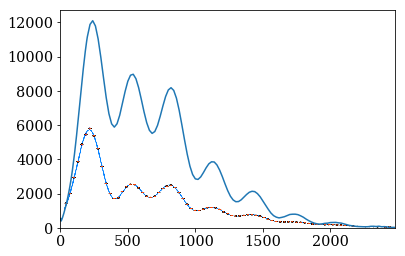

In [8]:
params_F = [As]
if True:
    """Compare to Planck 2015"""
    Cl0 = get_Cl(wd_F, Dwd_F, params_F)
    im = plt.imread('img/Cl_planck_30p.PNG')
    plt.imshow(im, extent=[30, 2500, 0, 6000], zorder=0, aspect='auto')
    plt.xlim(0, l_list[-1])
    plt.plot(l_list, Cl0, zorder=1)
    plt.show()

### Error on $C_\ell$

Each $C_\ell$ value is a random variable, and these are assumed to be gaussian and uncorrelated. The simulation above produces the mean value of each $C_\ell$. The variance includes both cosmic variance and experimental error. We are using the following expressions (from [Bond, Efstathiou, Tegmark 2008](https://arxiv.org/abs/astro-ph/9702100))
\begin{equation}
\label{cl_err}
(\Delta C_\ell)^2 = \frac{2}{(2 \ell + 1)f_{\text{sky}}}
\left(
C_\ell + \bar{w}^{-1} \mathcal{B}^{-2}
\right)^2
\end{equation}
and
$$
\mathcal{B} = \exp \left[\frac{-\ell (\ell + 1)}{\ell_s^2}\right]
$$
Typical values of $\bar{w}$ and $\ell_s$ are given in the paper.

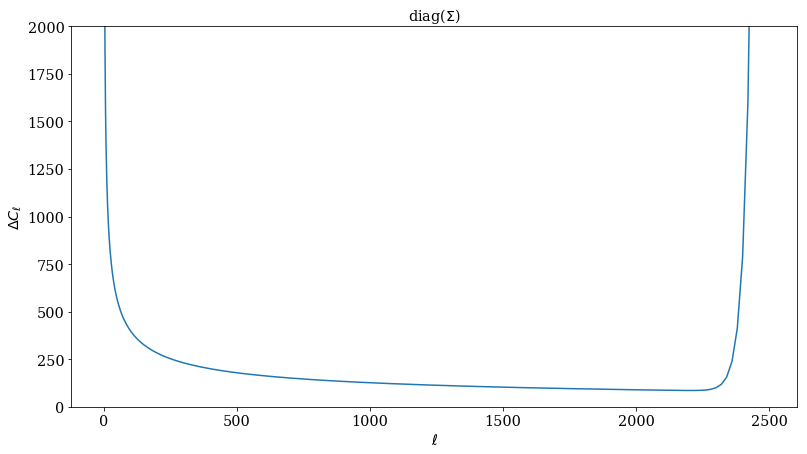

In [12]:
# Error:
f_sky = 1.0  # fraction of sky
l_s = 500.  # filtering scale
theta_pix = 0.0012  # rad
sigma_pix = 16.e-6
wbar = 1/(0.33e-15)
B_cl = np.exp(-l_list*(l_list + 1)/l_s**2)

# The expression below is more realistic because it includes the actual
# values of Cl.
ΔCl2 = (2/((2*l_list+1)*f_sky)) * (Cl0 + wbar**(-1) * B_cl**-2)**2
# The expression below is the one we are currently using, where Cl is 
# set to 4000 everywhere. This is less realistic but produces a nicer-looking
# curve.
ΔCl2 = (2/((2*l_list+1)*f_sky)) * (4000 + wbar**(-1) * B_cl**-2)**2
Sigma = np.diag(ΔCl2)

if settings['cosmic variance only']:
    """overwrite Cl error with values cosmic variance error"""
    ΔCl2 = 2/(2*l_list+1) 
    ΔCl2 =  4000 * 2/(2*l_list+1) 

plt.plot(l_list, np.sqrt(ΔCl2))
plt.title(r'diag($\Sigma$)')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell$')
plt.ylim(0, 2000)
plt.show()

With the assumption of Gaussian likelihood and uncorrelated $C_\ell$s, the likelihood is given by the expression below (from [Bond, Efstathiou, Tegmark 2008](https://arxiv.org/abs/astro-ph/9702100)).
\begin{equation}
\label{likelihood}
\mathcal{L}= \mathcal{L}_m \exp \left[-\frac{1}{2}
\sum_{ij} F_{ij} \delta s_i \delta s_j\right]
\end{equation}
Where $\mathcal{L}_m$ sets the numerical value of the maximum likelihood (which seems to be arbitrary?), $\delta_s$ is the deviation of $C_\ell$ from the mean, $F$ is the Fisher matrix

In [10]:
ScribdDocument(420488895, width=700, height=450,start_page=2,view_mode='scroll')

# PCA
Here is where we actually do PCA.

In [10]:
"""w-only PCA"""


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


def sinc(x):
    """Returns the sinc function s(x)=sin(πx)/(πx), with
    s(0)=1, evaluated on the array of points x."""
    out = np.zeros(len(x))
    out[x != 0] = sin(pi*x[x != 0])/(pi*x[x != 0])
    out[x == 0] = 1
    return out


def pca(t, basis_type, N_C):
    """This function does PCA. 
    Arguments:
    - t (int): sets the step size. stepsize = 10^(1-t).
    - basis_type (str): Sets the basis functions for PCA.
        can be 'square', 'cosine', 'gaussian', 'std' (standard) or 'sinc'.
        For the standard basis ('std'), for each point used in integration
        there is a basis function which is nonzero only at that point.
    - N_C (int): number of basis functions to use.
        
    The function does not return anything. Output is saved to a file with
    the name 'data/J_t-[t]_[basis_type].p', 'data/PC_t-[t]_[basis_type].p', and 
    'data/SV_t-[t]_[basis_type].p'. These are pickle files 
    (see https://docs.python.org/3/library/pickle.html) containing
    the matrix of partial derivatives, the principal components, and the 
    singular values respectively.
    
    For example, the function call
    > pca(6, 'square', 256)
    produces the following files:
    -'data/J_t-6_square_256.p'
    -'data/PC_t-6_square_256.p'
    -'data/SV_t-6_square_256.p'
    """
    # set derivative stepsize
    ss = 10**(1-t)

    # filenames:
    Bname = basis_type+"-"+str(N_C)
    Jname = "J_t"+"-"+str(t)+"_"+Bname
    PCname = "PC_t"+"-"+str(t)+"_"+Bname
    SVname = "SV_t"+"-"+str(t)+"_"+Bname

    # set the w basis
    B = np.zeros((N, N_C))
    if basis_type == 'cosine':
        for n in range(N_C):
            if n % 2 == 0:
                B[:, n] = cos((n/2)*np.arange(N)*pi/N)
            else:
                B[:, n] = sin(((n+1)/2)*np.arange(N)*pi/N)
    if basis_type == 'square':
        width = N//N_C
        for n in range(N_C):
            B[width*(n):width*(n+1), n] = 1/width
    if basis_type == 'gaussian':
        spacing = N/(N_C-1)
        width = spacing/2
        for n in range(N_C):
            B[:, n] = gaussian(np.arange(N), n*spacing, width)
    if basis_type == 'sinc':
        spacing = N/(N_C-1)
        for n in range(N_C):
            x = (np.arange(N)-n*spacing)/spacing
            B[:, n] = sinc(x)
    if basis_type == 'std':
        B = np.eye(N)/N

    for i in range(N):
        if τ_solve[i] < τ0_pca:
            B[i, :] = 0

    print('computing partials:')
    J = np.zeros((L, N_C))
    for n in range(N_C):
        Δwd = B[:, n]*ss
        ΔDwd = np.gradient(Δwd, τ_solve)
        Cl_fwd = get_Cl(wd_F + Δwd, Dwd + ΔDwd, params_F)
        Cl_bwd = get_Cl(wd_F - Δwd, Dwd - ΔDwd, params_F)
        J[:, n] = (Cl_fwd - Cl_bwd)/(2.*ss)
        if(n % 5 == 0):
            print(str(n) + ' of ' + str(N_C))

    # save the partials matrix and the basis matrix
    pickle.dump(J, open("data/"+Jname+".p", "wb"))
    pickle.dump(B, open("data/"+Bname+".p", "wb"))

    print('Partials saved. Computing PCs')
    try:
        # compute the Fisher matrix
        F = np.transpose(J)@np.linalg.inv(Sigma)@J
        # compute the svd.
        u, s, v = np.linalg.svd(F)
        D, V = np.linalg.eig(F)
        # principal vectors are currently defined as the rank-ordered left singular vectors
        PV = np.real(u) 
        PC = B@PV

        # flip and normalize the PCs
        for i in range(N_C):
            loc = np.argmax(np.abs(PC[:, i]))
            PC[:, i] *= np.sign(PC[loc, i])
            PC[:, i] /= np.linalg.norm(PC[:, i])

        pickle.dump(s, open("data/"+SVname+".p", "wb"))
        pickle.dump(PC, open("data/"+PCname+".p", "wb"))
        print('PCs saved.')
    except:
        print('svd failed')

In [11]:
if True:
    # loop through a broad range of step sizes and basis sizes
    # and save the results to pickle files.
    t = 7
    for l2n in range(4, 10):
        N_C = 2**l2n

        print('square basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'square', N_C)

        print('gaussian basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'gaussian', N_C)
        
        print('cosine basis', 't = '+str(t), 'N_C = '+str(N_C))
        pca(t, 'cosine', N_C)

square basis t = 7 N_C = 16
computing partials:
0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 16
computing partials:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
cosine basis t = 7 N_C = 16
computing partials:
0 of 16
5 of 16
10 of 16
15 of 16
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
cosine basis t = 7 N_C = 32
computing partials:
0 of 32
5 of 32
10 of 32
15 of 32
20 of 32
25 of 32
30 of 32
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 64
computing partials:
0 of 64
5 of 64
10 of 64
15 of 64
20 of 64
25 of 64
30 of 64
35 of 64
40 of 64
45 of 64
50 of 64
55 of 64
60 of 64
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 64
computing partials:
0 of 64
5 of 64
10 of 64
15 of 64
20 of 64
25 of 64
30 of 64
35 of 64
40 of 64
45 of 64
50 of 64

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in true_divide


0 of 64
5 of 64
10 of 64
15 of 64
20 of 64
25 of 64
30 of 64
35 of 64
40 of 64
45 of 64
50 of 64
55 of 64
60 of 64
Partials saved. Computing PCs
PCs saved.
square basis t = 7 N_C = 128
computing partials:
0 of 128
5 of 128
10 of 128
15 of 128
20 of 128
25 of 128
30 of 128
35 of 128
40 of 128
45 of 128
50 of 128
55 of 128
60 of 128
65 of 128
70 of 128
75 of 128
80 of 128
85 of 128
90 of 128
95 of 128
100 of 128
105 of 128
110 of 128
115 of 128
120 of 128
125 of 128
Partials saved. Computing PCs
PCs saved.
gaussian basis t = 7 N_C = 128
computing partials:
0 of 128
5 of 128
10 of 128
15 of 128
20 of 128
25 of 128
30 of 128
35 of 128
40 of 128
45 of 128
50 of 128
55 of 128
60 of 128
65 of 128
70 of 128
75 of 128
80 of 128
85 of 128
90 of 128
95 of 128
100 of 128
105 of 128
110 of 128
115 of 128
120 of 128
125 of 128
Partials saved. Computing PCs
PCs saved.
cosine basis t = 7 N_C = 128
computing partials:
0 of 128
5 of 128
10 of 128
15 of 128
20 of 128
25 of 128
30 of 128
35 of 128
40 of 1